In [1]:
!nvidia-smi

Sat Nov 19 11:34:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    25W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import sys
sys.path.append('/app/src')

import torchvision.datasets as dset
from torch.utils.data import DataLoader
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torchvision.transforms as T
from torchvision.utils import save_image, make_grid

from unet import UNetModel
from tqdm import tqdm
import math

In [3]:
device = 'cuda:0'

In [4]:
data_dir = Path('/app/data/anime/')
data_dir.mkdir(exist_ok=True, parents=True)

In [5]:
image_c = 3
image_size = 64

dataset = dset.ImageFolder(root=data_dir,
                           transform=T.Compose([
                               T.Resize(image_size),
                               T.CenterCrop(image_size),
                               T.ToTensor(),
                               # T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

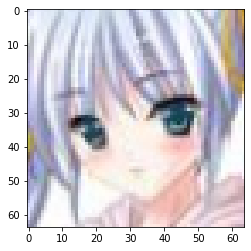

In [6]:
plt.imshow(dataset[6][0].permute(1, 2, 0))

In [7]:
train_dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4, drop_last=True)

In [8]:
def get_named_beta_schedule(schedule_name, num_diffusion_timesteps):
    """
    Get a pre-defined beta schedule for the given name.
    The beta schedule library consists of beta schedules which remain similar
    in the limit of num_diffusion_timesteps.
    Beta schedules may be added, but should not be removed or changed once
    they are committed to maintain backwards compatibility.
    """
    if schedule_name == "linear":
        # Linear schedule from Ho et al, extended to work for any number of
        # diffusion steps.
        scale = 1000 / num_diffusion_timesteps
        beta_start = scale * 0.0001
        beta_end = scale * 0.02
        return np.linspace(
            beta_start, beta_end, num_diffusion_timesteps, dtype=np.float32
        )
    elif schedule_name == "cosine":
        return betas_for_alpha_bar(
            num_diffusion_timesteps,
            lambda t: math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2,
        )
    else:
        raise NotImplementedError(f"unknown beta schedule: {schedule_name}")


def betas_for_alpha_bar(num_diffusion_timesteps, alpha_bar, max_beta=0.999):
    """
    Create a beta schedule that discretizes the given alpha_t_bar function,
    which defines the cumulative product of (1-beta) over time from t = [0,1].
    :param num_diffusion_timesteps: the number of betas to produce.
    :param alpha_bar: a lambda that takes an argument t from 0 to 1 and
                      produces the cumulative product of (1-beta) up to that
                      part of the diffusion process.
    :param max_beta: the maximum beta to use; use values lower than 1 to
                     prevent singularities.
    """
    betas = []
    for i in range(num_diffusion_timesteps):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    return np.array(betas)

class DDPM(nn.Module):
    def __init__(self, T = 1000):
        super(DDPM, self).__init__()
        
        self.diffuser = UNetModel(in_channels=3, 
                                   model_channels=256, 
                                   num_heads=4, 
                                   channel_mult = (1, 2, 3, 4), 
                                   out_channels=3, 
                                   num_res_blocks=2, 
                                   attention_resolutions=[4, 8])

        self.T = T
        self.betas = torch.tensor(get_named_beta_schedule('cosine', self.T)).to(device).to(torch.float32)
        self.a = 1. - self.betas
        self.a_hat = torch.cumprod(self.a, dim=0)
        
        self.a_hat_prev = torch.cat([torch.tensor([1], dtype=torch.float32).to(device), self.a_hat[:-1]], 0)
        self.posterior_variance = self.betas * (1 - self.a_hat_prev) / (1 - self.a_hat)
        self.posterior_log_variance_clipped = torch.log(self.posterior_variance.clamp(min=1e-20))
        
        self.sqrt_recip_a_hat = torch.rsqrt(self.a_hat)
        self.sqrt_recipm1_a_hat = torch.sqrt(1 / self.a_hat - 1)
        self.posterior_mean_coef1 = self.betas * torch.sqrt(self.a_hat_prev) / (1 - self.a_hat)
        self.posterior_mean_coef2 = (1 - self.a_hat_prev) * torch.sqrt(self.a) / (1 - self.a_hat)

    def forward(self, x0):
        t = torch.randint(self.T, (x0.size(0),)).to(device)
        eps = torch.randn_like(x0).to(device)
        
        a_hat_t = self.a_hat[t][:, None, None, None].to(device)
        
        pred_eps = self.diffuser(torch.sqrt(a_hat_t) * x0 +
                                 torch.sqrt(1 - a_hat_t) * eps, t.float()/self.T)
        losses_dict = self.diffuser.loss_function(pred_eps, eps)
        return losses_dict
    
    def predict_start_from_noise(self, x_t, t, noise):
        return (self.sqrt_recip_a_hat[t][:, None, None, None] * x_t - self.sqrt_recipm1_a_hat[t][:, None, None, None] * noise)
    
    def q_posterior(self, x_0, x_t, t):
        mean = (
            self.posterior_mean_coef1[t][:, None, None, None] * x_0 + self.posterior_mean_coef2[t][:, None, None, None] * x_t
        )
        var = self.posterior_variance[t][:, None, None, None]
        log_var_clipped = self.posterior_log_variance_clipped[t][:, None, None, None]

        return mean, var, log_var_clipped
    
    def p_mean_variance(self, x, t, clip_denoised):
        noise = self.diffuser(x, t/self.T)
        x_recon = self.predict_start_from_noise(x, t, noise=noise)

        if clip_denoised:
            x_recon = x_recon.clamp(min=-1, max=1)

        mean, var, log_var = self.q_posterior(x_recon, x, t)

        return mean, var, log_var
    
    def p_sample(self, x, t, clip_denoised=True, repeat_noise=False):
        mean, _, log_var = self.p_mean_variance(x, t, clip_denoised)
        noise = torch.randn_like(x).to(device)
        shape = [x.shape[0]] + [1] * (x.ndim - 1)
        nonzero_mask = (1 - (t == 0).type(torch.float32)).view(*shape)

        return mean + nonzero_mask * torch.exp(0.5 * log_var) * noise
    
    @torch.no_grad()
    def p_sample_loop(self, n_samples, data_size):
        img = torch.randn([n_samples, *data_size]).to(device)

        for i in tqdm(reversed(range(self.T))):
            img = self.p_sample(
                img,
                i*torch.ones((n_samples)).to(img.device).to(torch.int64),
            )

        return img
    
    @torch.no_grad()
    def sample(self, n_samples, data_size):
        xT = torch.randn([n_samples, *data_size]).to(device)
        for t in tqdm(range(self.T, 0, -1)):
            z = torch.randn_like(xT) if t > 1 else 0
            k = ((1 - self.a[t-1])/math.sqrt(1 - self.a_hat[t-1])).to(xT.device)
            t_tensor = t*torch.ones((n_samples)).to(xT.device)/self.T
            sigma = torch.sqrt(1 - self.a[t-1]).to(xT.device)
            xT = 1/math.sqrt(self.a[t-1]) * (xT - k*self.diffuser(xT, t_tensor)) + z * sigma
        return xT
    
def normalize_image(img):
    img += 1.
    img /= 2.
    return img
    
def log_images(samples, i):
    img_grid = make_grid(samples, nrow=4, value_range=(-1, 1))
    norm_img = normalize_image(img_grid)
    save_image(norm_img, f"log_images/{i}_sample.png")
    if wandb.run is not None:
        images = wandb.Image(img_grid, caption="Random sampled images")

        wandb.log({"Samples": images, 'i': i})

In [9]:
import wandb
wandb.init(project='anime_faces_diffusion', name=f'ddpm_cosine-betas_unet_latent-256_diffusion')

wandb: Currently logged in as: nerlfield. Use `wandb login --relogin` to force relogin


In [10]:
model = DDPM().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [ ]:
num_epoch = 500
loss_vis_freq = 200

i = 0
epoch = 0

for epoch in range(epoch, num_epoch, 1):
    model.train()
    for batch in train_dataloader:
        batch = batch[0].to(device) #only images
        losses_dict = model(batch)
        
        loss = losses_dict['loss']

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if wandb.run is not None:
            wandb.log({'loss': loss.item(),
                       'i': i})
        elif i % loss_vis_freq == 0:
            print(loss.item())
        
        i += 1
        # break
    
    with torch.inference_mode():
        model.eval()
        samples = model.p_sample_loop(16, (image_c, image_size, image_size))
        log_images(samples, i)


In [ ]:
model.sqrt_recipm1_a_hat.shape

# overfit

In [ ]:
# for batch in train_dataloader:
#     batch = batch[0].to(device)
#     break

In [ ]:
# num_epoch = 1000
# loss_vis_freq = 200

# i = 0
# for epoch in range(num_epoch):
#     model.train()
#     for wsefd in range(1000):
#         losses_dict = model(batch)

#         loss = losses_dict['loss']

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         if wandb.run is not None:
#             wandb.log({'loss': loss.item(),
#                        'i': i})
#         elif i % loss_vis_freq == 0:
#             print(loss.item())

#         i += 1
        
#     model.eval()
#     samples = model.sample(32, (1, 28, 28))
#     log_images(samples, i)